In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/divvy_data.csv')

In [3]:
data.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,...,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,...,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,...,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,...,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,...,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


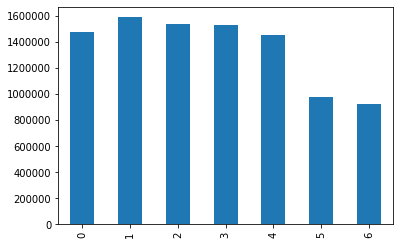

In [4]:
data['day'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [5]:
data['date'] = pd.to_datetime(data['starttime']).dt.date
d = data.groupby('date')['events'].agg({lambda x: x.value_counts().index[0]})
d['rides'] = data.groupby('date')['starttime'].count()
d['temperature'] = data.groupby('date')['temperature'].mean()
d.rename(columns={'<lambda>': 'weather'}, inplace=True)
d.reset_index(level=0, inplace=True)

In [6]:
d.head()

,date,weather,rides,temperature
0,2014-01-01,rain or snow,95,19.483158
1,2014-01-02,rain or snow,111,16.833333
2,2014-01-03,cloudy,6,-5.633333
3,2014-01-04,rain or snow,181,30.007735
4,2014-01-05,rain or snow,32,16.756250


In [7]:
d.tail()

,date,weather,rides,temperature
1453,2017-12-27,cloudy,1117,2.458013
1454,2017-12-28,rain or snow,1267,10.802762
1455,2017-12-29,cloudy,1049,12.978932
1456,2017-12-30,cloudy,519,3.657033
1457,2017-12-31,cloudy,593,8.657167


In [8]:
d.weather.unique()

array(['rain or snow', 'cloudy', 'clear', 'not clear'], dtype=object)

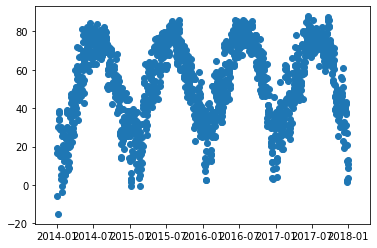

In [9]:
plt.scatter(x=d['date'], y=d['temperature'])

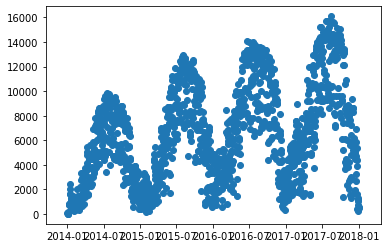

In [10]:
plt.scatter(d.date, d.rides)

In [11]:
df = pd.DataFrame()
df['ds'] = d['date']
df['y'] = d['rides']
df['temp'] = d['temperature']
df = pd.concat([df, pd.get_dummies(d['weather'], drop_first=True)], axis=1)
df['cap'] = 15000
df['floor'] = 0

In [12]:
df.head()

,ds,y,temp,cloudy,not clear,rain or snow,cap,floor
0,2014-01-01,95,19.483158,0,0,1,15000,0
1,2014-01-02,111,16.833333,0,0,1,15000,0
2,2014-01-03,6,-5.633333,1,0,0,15000,0
3,2014-01-04,181,30.007735,0,0,1,15000,0
4,2014-01-05,32,16.756250,0,0,1,15000,0


In [13]:
df.tail()

,ds,y,temp,cloudy,not clear,rain or snow,cap,floor
1453,2017-12-27,1117,2.458013,1,0,0,15000,0
1454,2017-12-28,1267,10.802762,0,0,1,15000,0
1455,2017-12-29,1049,12.978932,1,0,0,15000,0
1456,2017-12-30,519,3.657033,1,0,0,15000,0
1457,2017-12-31,593,8.657167,1,0,0,15000,0


In [14]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(df[d['date'] < pd.to_datetime('2017-01-01')])
future = m.make_future_dataframe(periods=365, freq='d')
forecast = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


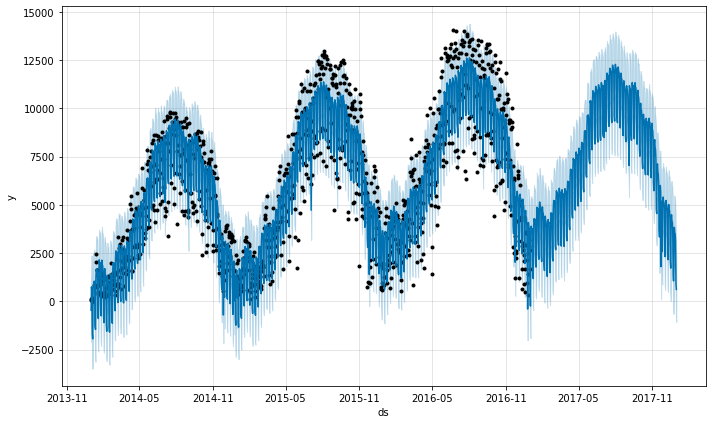

In [15]:
fig1 = m.plot(forecast)

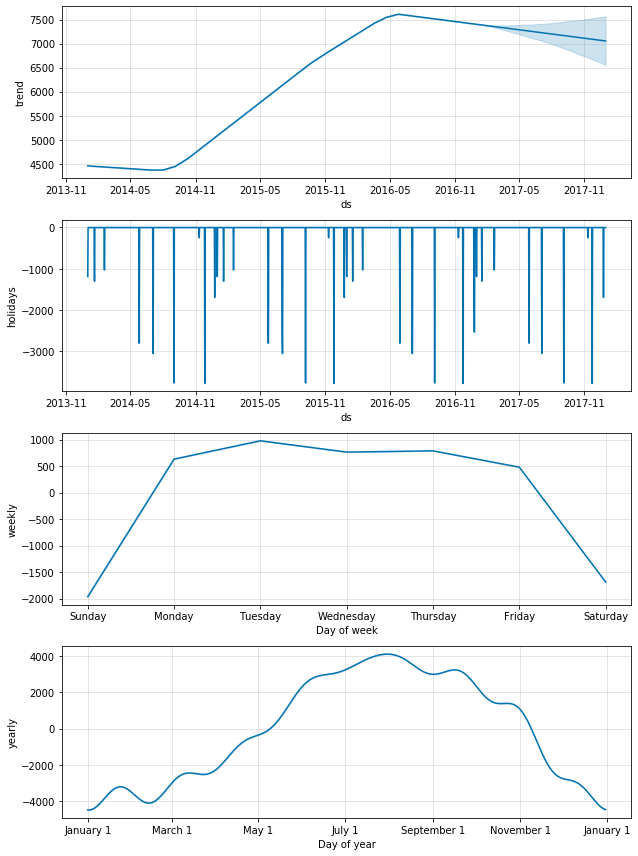

In [16]:
fig2 = m.plot_components(forecast)

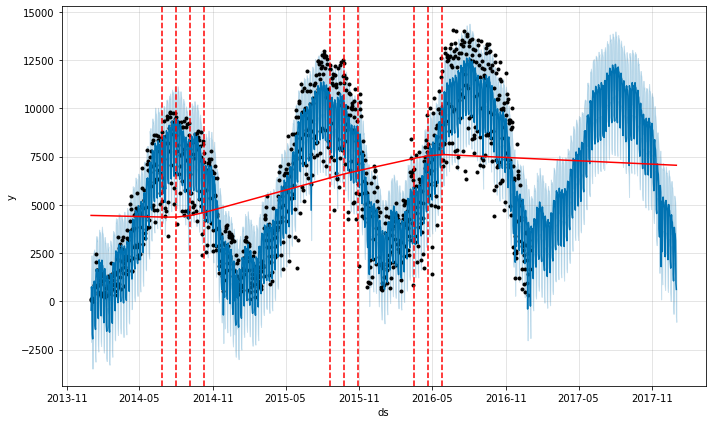

In [17]:
a = add_changepoints_to_plot(m.plot(forecast).gca(), m, forecast)

In [18]:
#dataframe of annual US Public Holidays over training and forecasting periods 

ny = pd.DataFrame({'holiday': "New Year's Day",
                   'ds' : pd.to_datetime(['2014-01-01',
                                          '2015-01-01',
                                          '2016-01-01',
                                          '2017-01-01',
                                          '2018-01-01',
                                          '2019-01-01'])})  
mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.',
                    'ds' : pd.to_datetime(['2014-01-20',
                                           '2015-01-19',
                                           '2016-01-18',
                                           '2017-01-16',
                                           '2018-01-15',
                                           '2019-01-21'])}) 
wash = pd.DataFrame({'holiday': "Washington's Birthday",
                     'ds' : pd.to_datetime(['2014-02-17',
                                            '2015-02-16',
                                            '2016-02-15',
                                            '2017-02-20',
                                            '2018-02-19',
                                            '2019-02-18'])})
mem = pd.DataFrame({'holiday': 'Memorial Day',
                    'ds' : pd.to_datetime(['2014-05-26',
                                           '2015-05-25',
                                           '2016-05-30',
                                           '2017-05-29',
                                           '2018-05-28',
                                           '2019-05-27'])})
ind = pd.DataFrame({'holiday': 'Independence Day',
                    'ds' : pd.to_datetime(['2014-07-04',
                                           '2015-07-04',
                                           '2016-07-04',
                                           '2017-07-04',
                                           '2018-07-04',
                                           '2019-07-04'])})
lab = pd.DataFrame({'holiday': 'Labor Day',
                    'ds' : pd.to_datetime(['2014-09-01',
                                           '2015-09-07',
                                           '2016-09-05',
                                           '2017-09-04',
                                           '2018-09-03',
                                           '2019-09-02'])})
col = pd.DataFrame({'holiday': 'Columbus Day',
                    'ds' : pd.to_datetime(['2014-10-13',
                                           '2015-10-12',
                                           '2016-10-10',
                                           '2017-10-09',
                                           '2018-10-08',
                                           '2019-10-14'])})
vet = pd.DataFrame({'holiday': "Veteran's Day",
                    'ds' : pd.to_datetime(['2014-11-11',
                                           '2015-11-11',
                                           '2016-11-11',
                                           '2017-11-11',
                                           '2018-11-11',
                                           '2019-11-11'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day',
                       'ds' : pd.to_datetime(['2014-11-27',
                                              '2015-11-26',
                                              '2016-11-24',
                                              '2017-11-23',
                                              '2018-11-22',
                                              '2019-11-28']),
                       'lower_window': 0,
                       'upper_window': 1})
christ = pd.DataFrame({'holiday': 'Christmas',
                       'ds' : pd.to_datetime(['2014-12-25',
                                              '2015-12-25',
                                              '2016-12-25',
                                              '2017-12-25',
                                              '2018-12-25',
                                              '2019-12-25']),
                       'lower_window': -1,
                       'upper_window': 0})

holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ], sort=True)

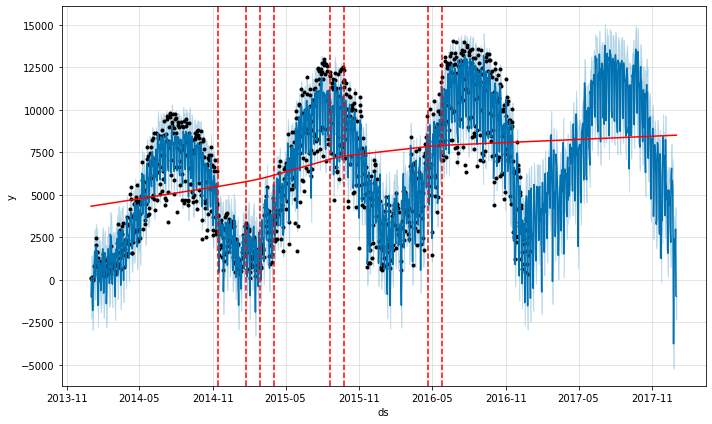

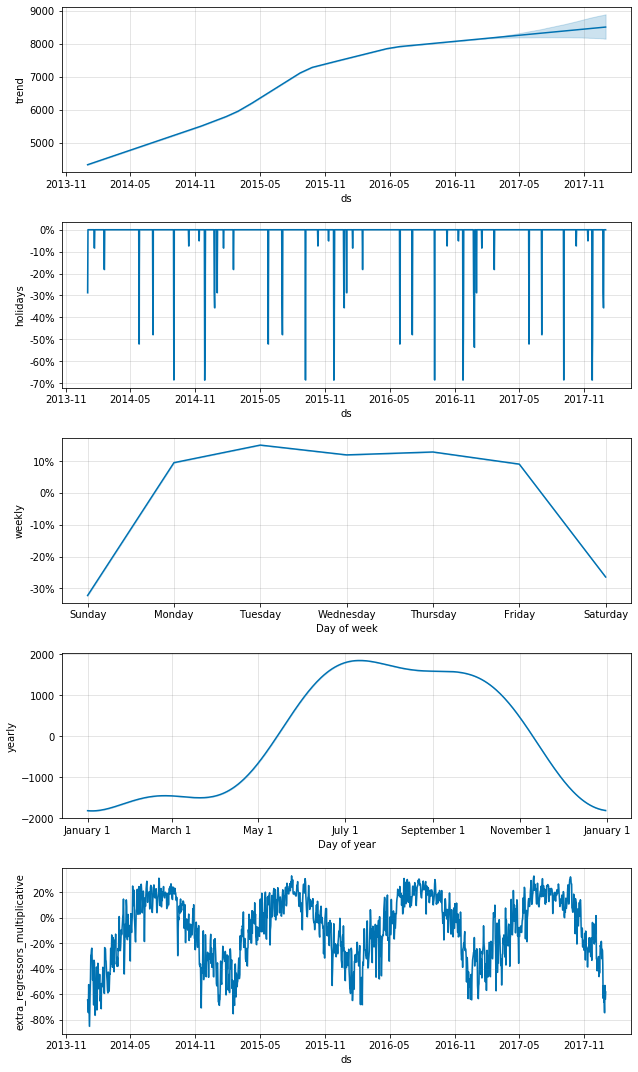

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 00:00:00 and 2016-01-01 00:00:00


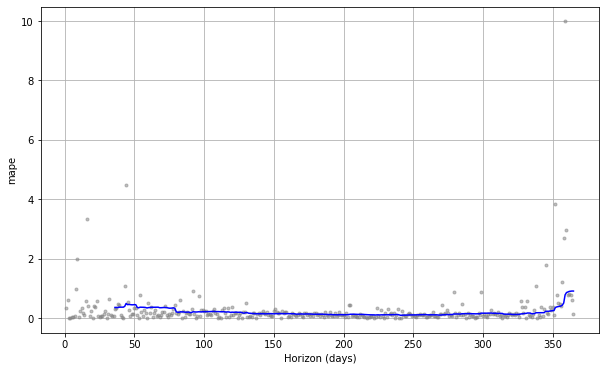

mape: 19.64%


In [19]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  holidays=holidays,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive'
                  )
prophet.add_country_holidays(country_name='US')
prophet.add_regressor('temp')
prophet.add_regressor('cloudy')
prophet.add_regressor('not clear')
prophet.add_regressor('rain or snow')
prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365, freq='D')
future['temp'] = df['temp']
future['cloudy'] = df['cloudy']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

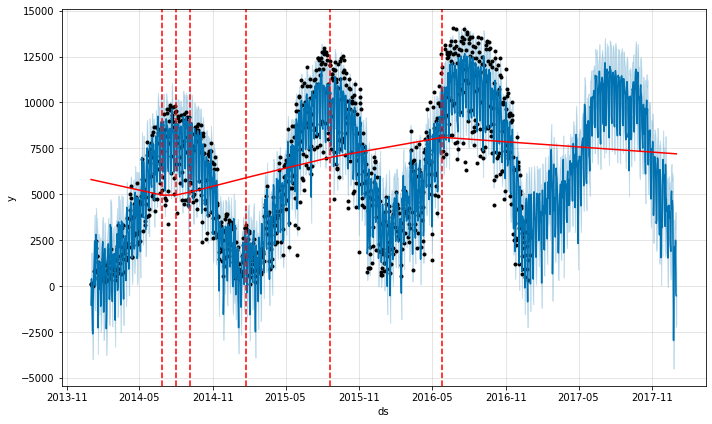

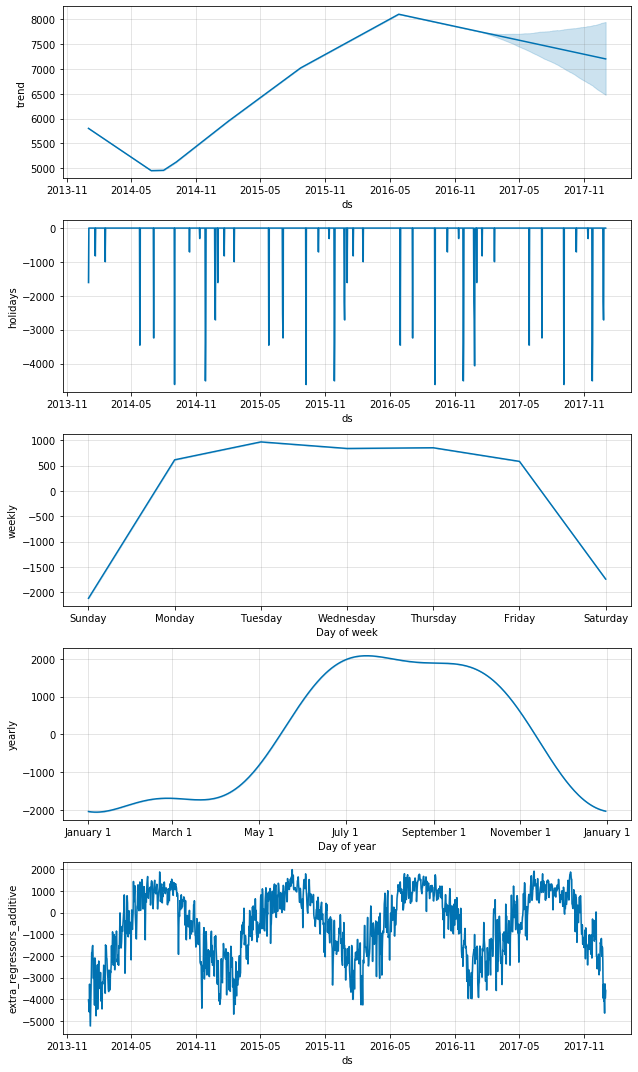

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 00:00:00 and 2016-01-01 00:00:00


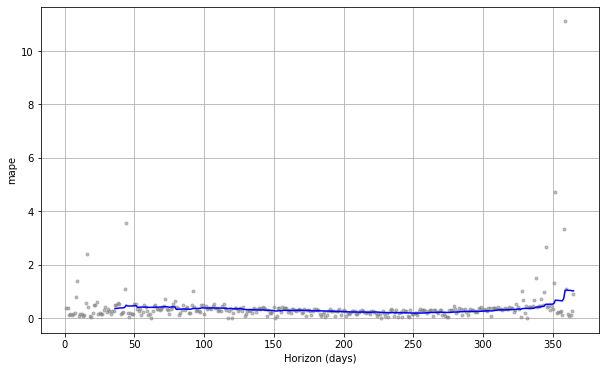

mape: 32.53%


In [20]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  holidays=holidays,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive'
                  )
prophet.add_country_holidays(country_name='US')
prophet.add_regressor('temp')
prophet.add_regressor('cloudy')
prophet.add_regressor('not clear')
prophet.add_regressor('rain or snow')
prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365, freq='D')
future['temp'] = df['temp']
future['cloudy'] = df['cloudy']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

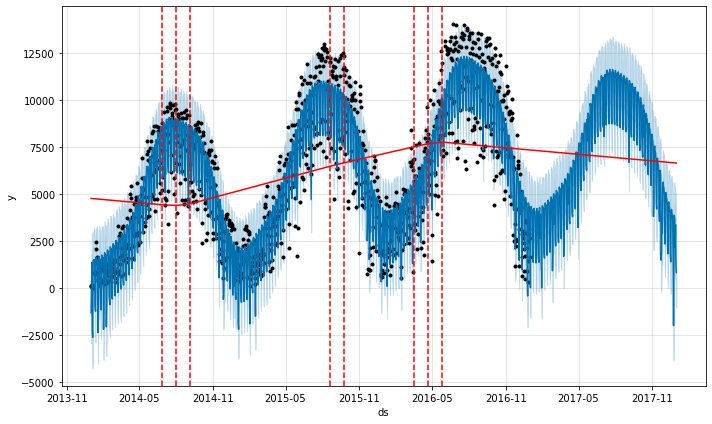

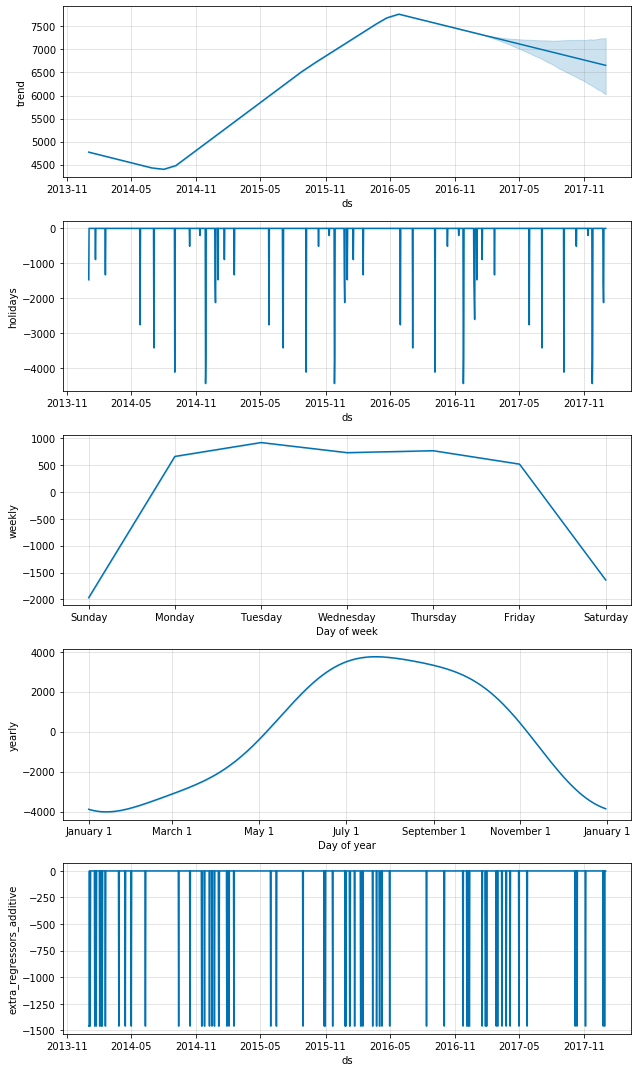

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 00:00:00 and 2016-01-01 00:00:00


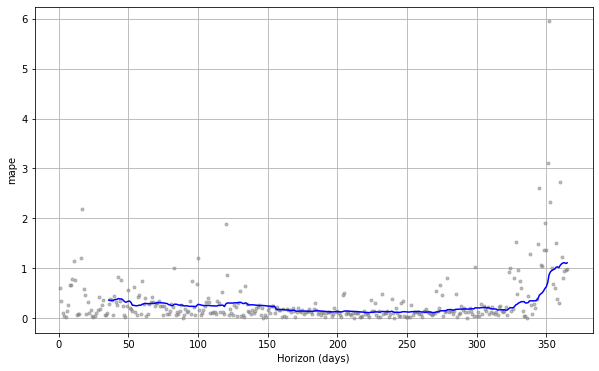

mape: 25.02%


In [21]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  holidays=holidays,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive'
                  )
prophet.add_country_holidays(country_name='US')

prophet.add_regressor('rain or snow')

prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365, freq='D')

future['rain or snow'] = df['rain or snow']

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


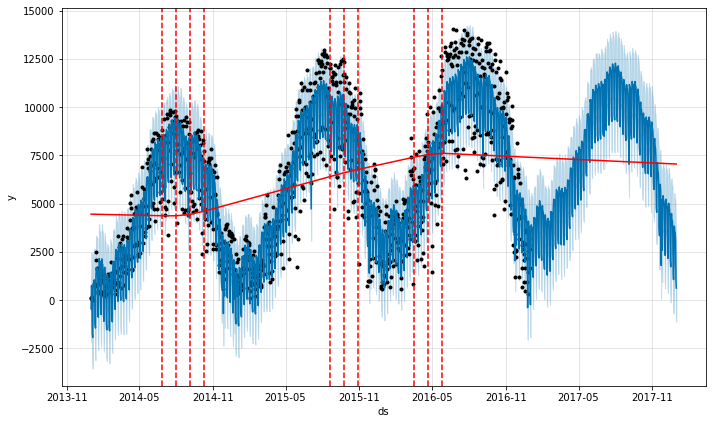

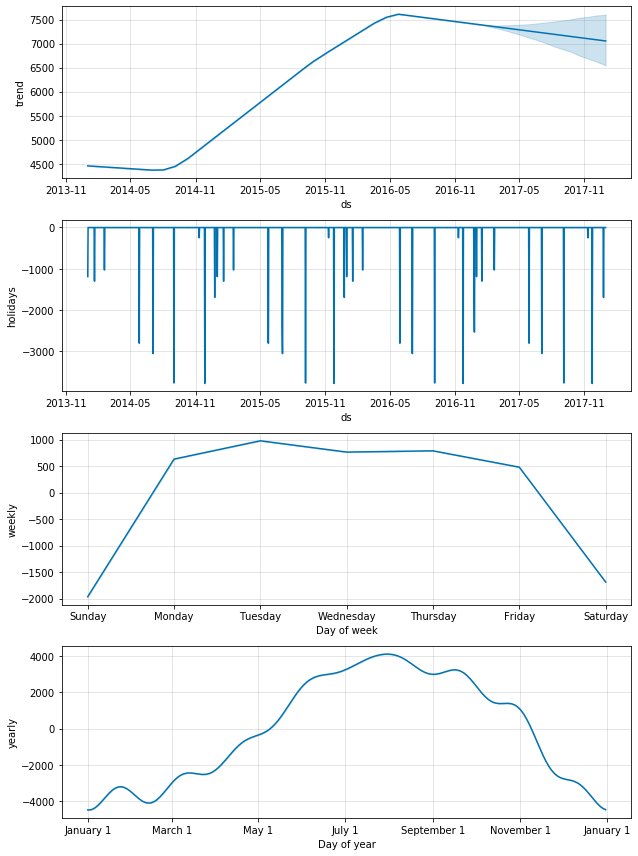

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 00:00:00 and 2016-01-01 00:00:00


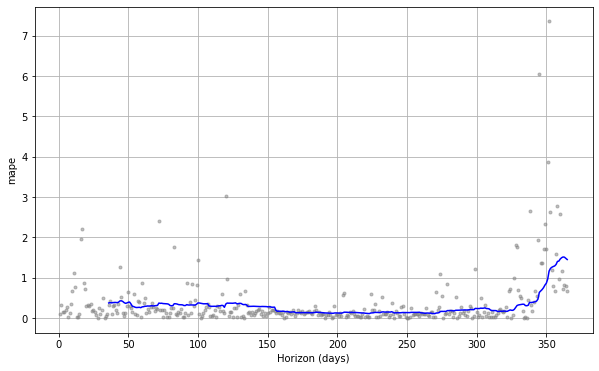

mape: 29.18%


In [22]:
prophet = Prophet()
prophet.add_country_holidays(country_name='US')
prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

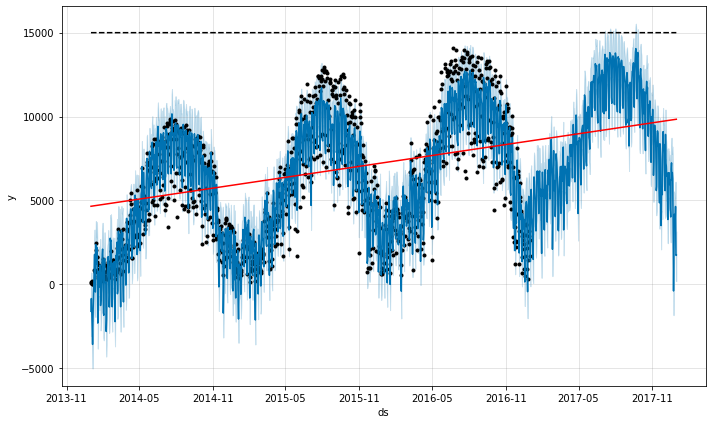

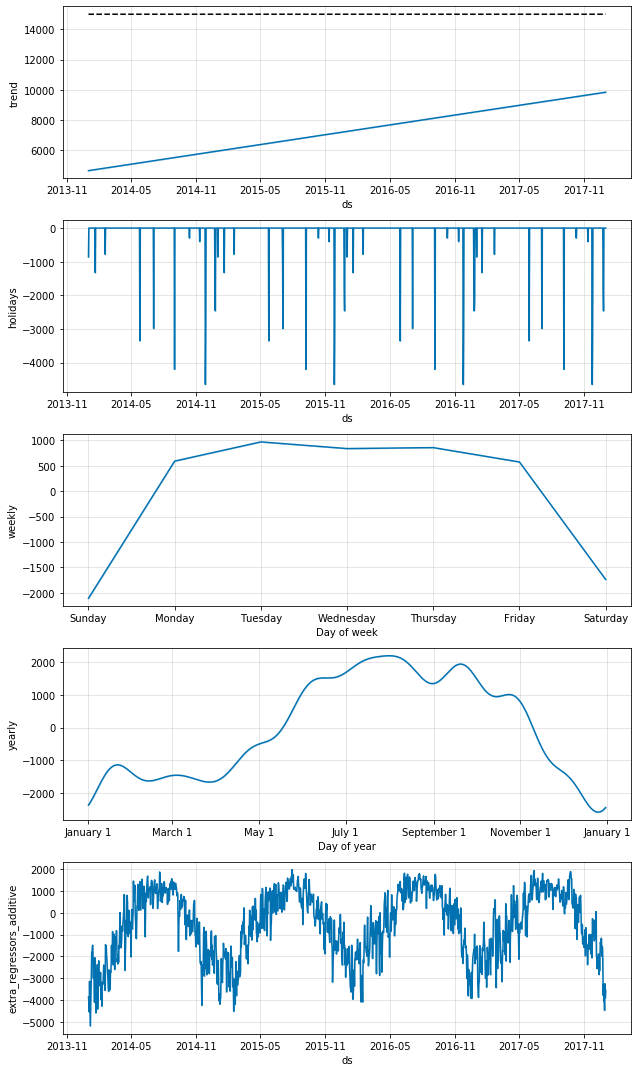

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 00:00:00 and 2016-01-01 00:00:00


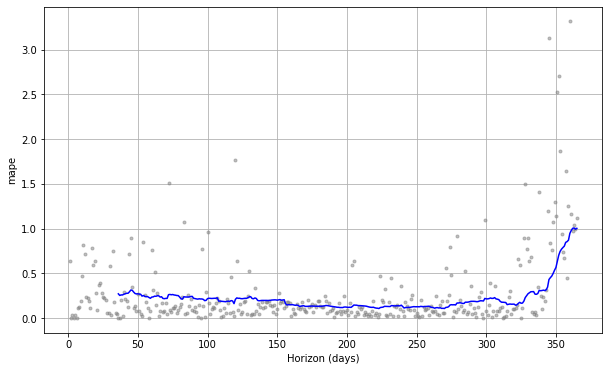

mape: 22.09%


In [23]:
prophet = Prophet(growth='linear',
                  n_changepoints=25,
                  changepoint_range=0.8,
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  holidays=holidays,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.01,
                  mcmc_samples=0)
prophet.add_country_holidays(country_name='US')
prophet.add_regressor('temp', mode='additive')
prophet.add_regressor('cloudy', mode='additive')
prophet.add_regressor('not clear', mode='additive')
prophet.add_regressor('rain or snow', mode='additive')
prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365, freq='D')
future['temp'] = df['temp']
future['cloudy'] = df['cloudy']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
future['cap'] = df['cap']
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))